<a href="https://colab.research.google.com/github/MarkMData/DABI_project/blob/main/Diss_workflow1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First attempt at workflow

In [ ]:
!pip install pysal
!pip install scikit-gstat
!pip install gstools
import gstools as gs
import skgstat as skg
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pysal.viz import splot
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from pysal.explore import esda
from pysal.lib import weights
from splot import esda as esdaplot
from shapely import wkt
pd.set_option("mode.copy_on_write", True)


# Loading geo data back in and converting it to a geo data frame that cam be used
# for choropleth mapping
geo = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/lads.csv')
geo['geometry'] = geo['geometry'].apply(wkt.loads)
geo_gdf = gpd.GeoDataFrame(geo)

In [40]:
# Adding predictors to gdf
data = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/diss_data2.csv')
data.loc[data['local_authority'] == 'Southampton', 'alcohol_admissions'] = np.median(data['alcohol_admissions'])
merged_df = pd.merge(geo_gdf, data, on=['local_authority', 'active'], how='left')
# Convert the resulting DataFrame back to a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

In [ ]:
# Setting gemotry to centroids and CRS as EPSG:27700
gdf.geometry = gdf.geometry.centroid
gdf.set_crs('EPSG:27700', inplace=True)

In [49]:
# getting centroids from geometries scale is in meters (British National Grid CRS (EPSG: 27700) )
gdf['x'] =  gdf.geometry.centroid.x
gdf['y'] = gdf.geometry.centroid.y

Text(0.5, 1.0, 'Scatter Plot')

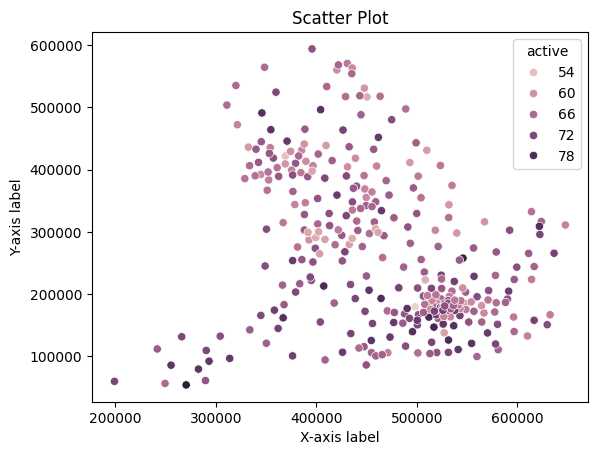

In [80]:
# Plotting centroids as a sanity check
target = 'active'
sns.scatterplot(data=gdf, x='x', y='y', hue = target)
# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter Plot')

In [79]:
# Creating weights using adaptive kernel for the training data
w_kern = weights.distance.Kernel.from_dataframe(gdf, fixed=False, k=6, diagonal=True)
w_kern = weights.fill_diagonal(w_kern, val=0.0)
# Row-standardization
w_kern.transform = "R"
# calculating morans I
moran = esda.moran.Moran(gdf[target], w_kern)
print(moran.I)
print(moran.p_sim)
print(moran.z_sim)

0.24194600682680015
0.001
6.206146074915458


In [45]:
# Changing scale of distances to km
x = gdf['x']/1000
y = gdf['y']/1000
t = gdf[target]
coords = np.column_stack((x,y))

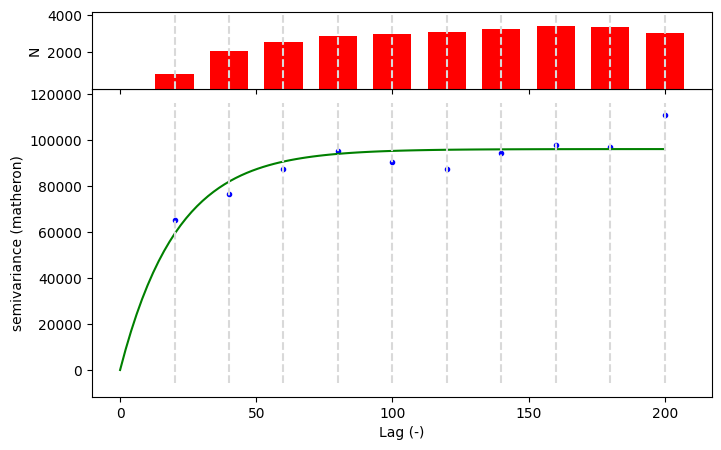

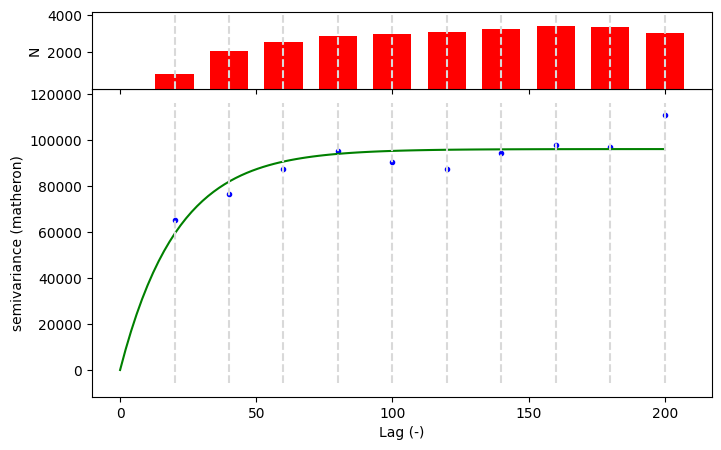

In [70]:
# plotting variogram
V = skg.Variogram(coords, t, normalize=False, model='exponential', maxlag= 200)
V.plot()

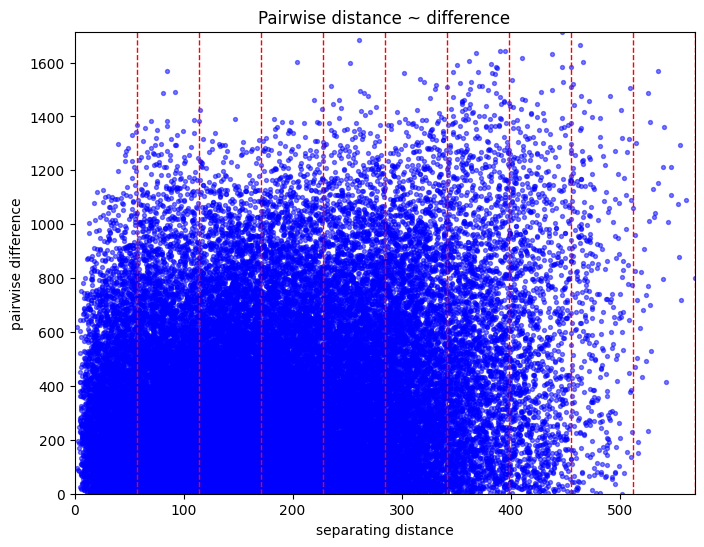

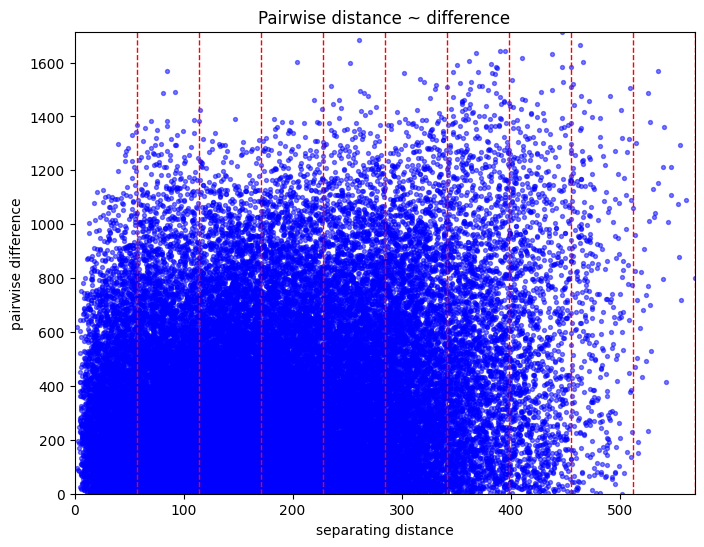

In [68]:
V.distance_difference_plot()

In [ ]:
!pip install spatial-kfold
from spatialkfold.clusters import spatial_kfold_clusters

In [20]:
ames_clusters = spatial_kfold_clusters (gdf=gdf, name='local_authority', nfolds=10, algorithm='kmeans', random_state=569)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


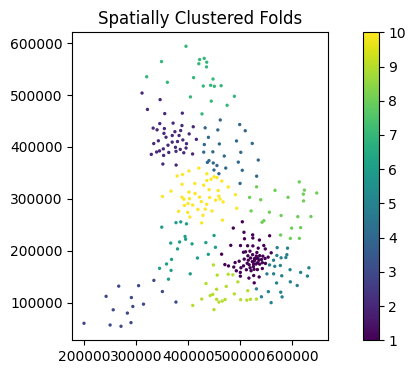

In [21]:
fig, ax = plt.subplots(1,1 , figsize=(9, 4))
ames_clusters.plot(column='folds', ax=ax,  markersize = 2, legend=True)
ax.set_title('Spatially Clustered Folds')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


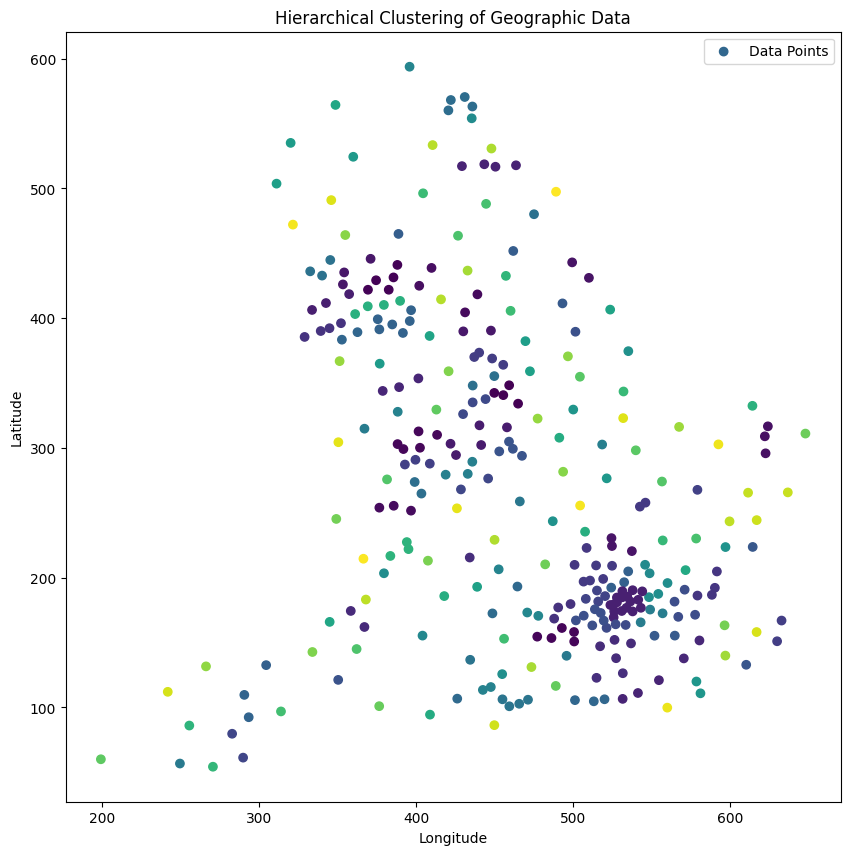

Number of clusters: 170


In [74]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances between points
data = np.column_stack((x, y))
distances = squareform(pdist(data))

# Set the maximum distance for cluster membership
max_distance = 200.0

# Perform hierarchical clustering
clustering = AgglomerativeClustering(distance_threshold = max_distance, n_clusters=None,linkage='average')
labels = clustering.fit_predict(distances)

# Plot the clusters
plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', label='Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hierarchical Clustering of Geographic Data')
plt.legend()
plt.show()
print(f'Number of clusters: {clustering.n_clusters_}')

In [77]:
clustering.children_

array([[110, 133],
       [107, 132],
       [292, 307],
       [139, 239],
       [265, 281],
       [ 55, 170],
       [ 42, 224],
       [166, 178],
       [ 43, 308],
       [168, 270],
       [202, 238],
       [138, 147],
       [161, 247],
       [157, 278],
       [127, 199],
       [  0, 302],
       [105, 144],
       [ 29,  76],
       [112, 315],
       [ 91, 253],
       [ 86, 237],
       [ 37, 183],
       [207, 240],
       [102, 191],
       [ 51, 263],
       [  7, 120],
       [235, 300],
       [152, 271],
       [194, 277],
       [ 70,  92],
       [ 75, 213],
       [172, 245],
       [310, 320],
       [ 22, 293],
       [ 18, 185],
       [ 88, 136],
       [216, 287],
       [ 99, 236],
       [ 19, 129],
       [ 40, 201],
       [ 31, 143],
       [193, 299],
       [221, 296],
       [ 33, 182],
       [ 94, 330],
       [309, 325],
       [ 90, 113],
       [  8,  89],
       [142, 341],
       [252, 298],
       [115, 124],
       [ 66, 326],
       [108,

In [ ]:
# Dendrogram of correlations using complete linkage
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
sns.set(rc={'figure.figsize':(6,6)})

